[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PTB-MR/mrpro/blob/main/examples/notebooks/iterative_sense_reconstruction_with_regularization.ipynb) [![Download notebook](https://img.shields.io/badge/Download-notebook-blue?logo=jupyter)](path:iterative_sense_reconstruction_with_regularization.ipynb)

In [1]:
import importlib

if not importlib.util.find_spec('mrpro'):
    %pip install mrpro[notebooks]

# Regularized iterative SENSE reconstruction of 2D golden angle radial data
Here we use the `~mrpro.algorithms.reconstruction.RegularizedIterativeSENSEReconstruction` class to reconstruct
undersampled images from 2D radial data.

In [2]:
# Download raw data from Zenodo
import tempfile
from pathlib import Path

import zenodo_get

dataset = '14617082'

tmp = tempfile.TemporaryDirectory()  # RAII, automatically cleaned up
data_folder = Path(tmp.name)
zenodo_get.zenodo_get([dataset, '-r', 5, '-o', data_folder])  # r: retries

Title: 2D Radial MR raw data and Pulseq sequences
Keywords: 
Publication date: 2025-01-08
DOI: 10.5281/zenodo.14617082
Total size: 18.7 MB

Link: https://zenodo.org/records/14617082/files/radial2D_24spokes_golden_angle_with_traj.h5   size: 858.7 kB



Checksum is correct. (9a82b5f9c6f27a3db64fd8f7be65cfa3)

Link: https://zenodo.org/records/14617082/files/radial2D_24spokes_golden_angle.seq   size: 29.3 kB



Checksum is correct. (d48ba3340d511a7e24dfc69031a3b6ac)

Link: https://zenodo.org/records/14617082/files/radial2D_402spokes_golden_angle.seq   size: 172.2 kB



Checksum is correct. (ff682e21d7d2434dc5b672523dfeacec)

Link: https://zenodo.org/records/14617082/files/radial2D_96spokes_golden_angle_with_traj.h5   size: 3.4 MB



Checksum is correct. (9fc6d03790b1cf293cbd83939a1dd752)

Link: https://zenodo.org/records/14617082/files/radial2D_402spokes_golden_angle_with_traj.h5   size: 14.2 MB



Checksum is correct. (54d083c0040d3674317006cbaaa95420)

Link: https://zenodo.org/records/14617082/files/radial2D_96spokes_golden_angle.seq   size: 55.9 kB



Checksum is correct. (449434bf7b5e609d09cf5d42cf27c7f3)
All files have been downloaded.


### Image reconstruction
We use the `~mrpro.algorithms.reconstruction.RegularizedIterativeSENSEReconstruction` class to reconstruct images
from 2D radial data. It solves the following reconstruction problem:

Let's assume we have obtained the k-space data $y$ from an image $x$ with an acquisition model (Fourier transforms,
coil sensitivity maps...) $A$ then we can formulate the forward problem as:

$ y = Ax + n $

where $n$ describes complex Gaussian noise. The image $x$ can be obtained by minimizing the functional $F$

$ F(x) = ||Ax - y||_2^2 + \lambda||Bx - x_\mathrm{reg}||_2^2$

where $\lambda$ is the strength of the regularization, $B$ is a linear operator and $x_\mathrm{reg}$ is a
regularization image.
With this functional $F$ we obtain a solution which is close to $x_\mathrm{reg}$ and to the acquired data $y$.

Setting the derivative (see https://www.matrixcalculus.org) of the functional $F$ to zero and rearranging yields

$ (A^H A + l B^H B) x = A^H y + \lambda B^H x_\mathrm{reg}$

which is a linear system $Hx = b$ that needs to be solved for $x$.

One important question of course is, what to use as $x_\mathrm{{reg}}$ and $B$. For dynamic images (e.g. cine MRI)
low-resolution dynamic images or high-quality static images have been proposed.
In recent years, the output of neural networks has also been used, i.e. $x_{\mathrm{reg}} = u_{\theta}(x_0)$
$B=\mathrm{Id}$ for a pre-trained network $u_{\theta}$ and initial image $x_0$ [[Kofler et al. 2020](https://doi.org/10.1088/1361-6560/ab990e)].

In this example we are going to use a high-quality image to regularize the reconstruction of an undersampled image.
Both images are obtained from the same data acquisition - one using all the acquired data ($x_{\mathrm{reg}}$),
and one using only parts of it ($x$). This is, of course, an unrealistic case but it will allow us to demonstrate
the effect of the regularization.

```{note}
In [Pruessmann et al. 2001](https://doi.org/10.1002/mrm.1241) the k-space density is used to reweight the
loss to achieve faster convergence. This increases reconstruction error, see [Ong F., Uecker M., Lustig M. 2020](https://doi.org/10.1109/TMI.2019.2954121).
We follow a recommendation by [Fessler and Noll](https://ece-classes.usc.edu/ee591/library/Fessler-Iterative%20Reconstruction.pdf)
and use the DCF to obtain a good starting point.
```

### Reading of both fully sampled and undersampled data
We read the raw data and the trajectory from the ISMRMRD file.
We load both, the fully sampled and the undersampled data.
The fully sampled data will be used to estimate the coil sensitivity maps and as a regularization image.
The undersampled data will be used to reconstruct the image.

In [3]:
# Read the raw data and the trajectory from ISMRMRD file
import mrpro

kdata_fullysampled = mrpro.data.KData.from_file(
    data_folder / 'radial2D_402spokes_golden_angle_with_traj.h5',
    mrpro.data.traj_calculators.KTrajectoryIsmrmrd(),
)
kdata_undersampled = mrpro.data.KData.from_file(
    data_folder / 'radial2D_24spokes_golden_angle_with_traj.h5',
    mrpro.data.traj_calculators.KTrajectoryIsmrmrd(),
)

##### Obtain image $x_{\mathrm{reg}}$ from fully sampled data
We first reconstruct the fully sampled image to use it as a regularization image.
In a real-world scenario, we would not have this image and would have to use a low-resolution image as a prior, or use
a neural network to estimate the regularization image.

In [4]:
# Estimate coil maps. Here we use the fully sampled data to estimate the coil sensitivity maps.
# In a real-world scenario, we would either a calibration scan (e.g. a separate fully sampled scan) to estimate the coil
# sensitivity maps or use ESPIRiT or similar methods to estimate the coil sensitivity maps from the undersampled data.
direct_reconstruction = mrpro.algorithms.reconstruction.DirectReconstruction(kdata_fullysampled)
csm = direct_reconstruction.csm
assert csm is not None

# unregularized iterative SENSE reconstruction of the fully sampled data
iterative_sense_reconstruction = mrpro.algorithms.reconstruction.IterativeSENSEReconstruction(
    kdata_fullysampled, csm=csm, n_iterations=3
)
img_iterative_sense = iterative_sense_reconstruction(kdata_fullysampled)

##### Image $x$ from undersampled data
We now reconstruct the undersampled image using the fully sampled image first without regularization,
and with a regularization image.

In [5]:
# Unregularized iterative SENSE reconstruction of the undersampled data
iterative_sense_reconstruction = mrpro.algorithms.reconstruction.IterativeSENSEReconstruction(
    kdata_undersampled, csm=csm, n_iterations=6
)
img_us_iterative_sense = iterative_sense_reconstruction(kdata_undersampled)

In [6]:
# Regularized iterative SENSE reconstruction of the undersampled data

regularized_iterative_sense_reconstruction = mrpro.algorithms.reconstruction.RegularizedIterativeSENSEReconstruction(
    kdata_undersampled,
    csm=csm,
    n_iterations=6,
    regularization_data=img_iterative_sense.data,
    regularization_weight=1.0,
)
img_us_regularized_iterative_sense = regularized_iterative_sense_reconstruction(kdata_undersampled)

##### Display the results
Besides the fully sampled image, we display two undersampled images:
The first one is obtained by unregularized iterative SENSE, the second one using regularization.

In [7]:
import matplotlib.pyplot as plt
import torch


def show_images(*images: torch.Tensor, titles: list[str] | None = None) -> None:
    """Plot images."""
    n_images = len(images)
    _, axes = plt.subplots(1, n_images, squeeze=False, figsize=(n_images * 3, 3))
    for i in range(n_images):
        axes[0][i].imshow(images[i], cmap='gray')
        axes[0][i].axis('off')
        if titles:
            axes[0][i].set_title(titles[i])
    plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


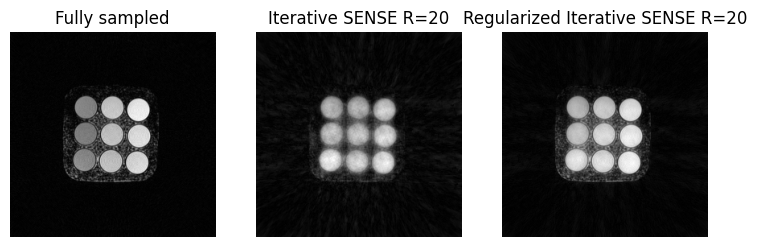

In [8]:
show_images(
    img_iterative_sense.rss()[0, 0],
    img_us_iterative_sense.rss()[0, 0],
    img_us_regularized_iterative_sense.rss()[0, 0],
    titles=['Fully sampled', 'Iterative SENSE R=20', 'Regularized Iterative SENSE R=20'],
)

### Behind the scenes
We now investigate the steps that are done in the regularized iterative SENSE reconstruction and
perform them manually. This also demonstrates how to use the `mrpro` operators and algorithms
to build your own reconstruction pipeline.

##### Set-up the acquisition model $A$

This is very similar to <project:iterative_sense_reconstruction_radial2D.ipynb> .
For more details, please refer to that notebook.

In [9]:
fourier_operator = mrpro.operators.FourierOp.from_kdata(kdata_undersampled)
csm_operator = csm.as_operator()
acquisition_operator = fourier_operator @ csm_operator

##### Set-up the right-hand side $b$
We calculate $b = A^H y + \lambda B^H x_\mathrm{reg}$, using the identity operator as $B$ and $\lambda = 1.0$.

In [10]:
regularization_weight = 1.0
regularization_image = img_iterative_sense.data
regularization_operator = mrpro.operators.IdentityOp()

(regularization,) = (regularization_weight * regularization_operator.H)(regularization_image)
(right_hand_side,) = (acquisition_operator.H)(kdata_undersampled.data)
right_hand_side = right_hand_side + regularization

##### Set-up the linear self-adjoint operator $H$
We define $H = A^H A + \lambda B^HB$. We can use `~mrpro.operators.LinearOperator.gram` to get an efficient
implementation of $A^H A$. We use the `~mrpro.operators.IdentityOp` and make
use of operator addition using ``+`` and multiplication using ``*``.
The resulting operator is a `~mrpro.operators.LinearOperator` object.

In [11]:
operator = acquisition_operator.gram + mrpro.operators.IdentityOp() * regularization_weight

##### Run conjugate gradient
We solve the linear system $Hx = b$ using the conjugate gradient method.
Here we use a density compensated adjoint reconstruction to obtain a good starting point,
$x_0 = A^H W y$ with $W$ being the density compensation operator.
We use a tolerance of $1e-7$ for the residual as a stopping criterion.

In [12]:
dcf_operator = mrpro.data.DcfData.from_traj_voronoi(kdata_undersampled.traj).as_operator()
(initial_value,) = (acquisition_operator.H @ dcf_operator)(kdata_undersampled.data)
(img_manual,) = mrpro.algorithms.optimizers.cg(operator, right_hand_side, initial_value=initial_value, tolerance=1e-7)

#####  Display the reconstructed image
We can now compare our 'manual' reconstruction with the regularized iterative SENSE reconstruction
obtained using `~mrpro.algorithms.reconstruction.RegularizedIterativeSENSEReconstruction`.

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


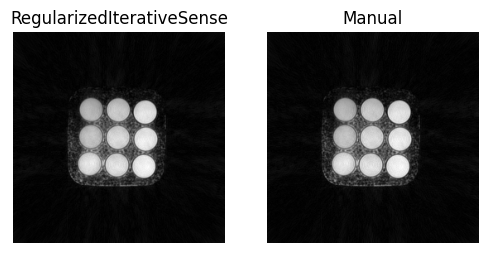

In [13]:
show_images(
    img_us_regularized_iterative_sense.rss()[0, 0],
    img_manual.abs()[0, 0, 0],
    titles=['RegularizedIterativeSense', 'Manual'],
)

We can verify the results by comparing the actual image data.
If the assert statement does not raise an exception, the results are equal.

In [14]:
torch.testing.assert_close(img_us_regularized_iterative_sense.data, img_manual)

### Next steps

We are cheating here because we used the fully sampled image as a regularization. In real world applications
we would not have that. One option is to apply a low-pass filter to the undersampled k-space data to try to reduce the
streaking artifacts and use that as a regularization image. Try that and see if you can also improve the image quality
compared to the unregularized images.